## EXPERIMENT 2.2: AdaFace

In [1]:
## Load libraries

import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import sys
sns.set(style="white")
%matplotlib inline
sys.path.append('../../utils')
from Model_utils.Model_funcs import *
from Result_metric_utils.result_metrics import *
from Data_proc_utils.Data_proc_funcs import *
from Plotting_stats_utils.plotting_threshold import *
from Plotting_stats_utils.stats_tables import *


from IPython import embed
from scipy import stats


In [2]:
# Save figures
from matplotlib import pyplot as plt
save_fig_path = '../../figures/ada_2_2/'


### AdaFace Results

This notebook loads the feature vectors from MagFace and run them through the results metrics:
FNIR, FPIR, FND, FPD, and GARBE

In [3]:
feature_list_children = '../../data/data_full/feature_vectors/adaface_feature_vectors/2.2/similarity_scores_children_bibel_FINAL_INFERENCE_finetuning_2_2_ofsi_final.pt'
feature_list_adults = '../../data/data_full/feature_vectors/adaface_feature_vectors/2.2/similarity_scores_adults_bibel_retina_FINAL_INFERENCE_finetuning_2_2_ofsi_final.pt'


image_names_c, ids_c, num_ids_c, norm_feats_c = load_adaface_vectors(feature_list_children)
image_names_a, ids_a, num_ids_a, norm_feats_a = load_adaface_vectors(feature_list_adults)
# image_names_a, ids_a, num_ids_a, norm_feats_a = load_adaface_vectors_adults(feature_list_adults) # virker for den gamle, men ikke de cropped af en eller anden grund

ids_a = ["_".join(x.split("_")[1:]) for x in ids_a]


# Similarity matrices from adaface - all
sim_mat_c = np.dot(norm_feats_c, norm_feats_c.T)
sim_mat_a = np.dot(norm_feats_a, norm_feats_a.T)


# Dataframes with info, removes names not in magface results
children_all = pd.read_csv('../../data/image_info_csvs/final_filtered_children_df_BIBEL.csv')
children_all = children_all[children_all.image_name.isin(image_names_c)]

adults_all_org = pd.read_csv('../../data/image_info_csvs/final_filtered_adults_df_BIBEL.csv')
adults_all = adults_all_org[adults_all_org.image_name.isin(image_names_a)]

# Finding the right threshold

In [4]:
random_states = [1,2]
percentiles = np.arange(0.0, 1.0, 0.03).tolist()

df_all_threshold_x = compute_metrics_ex_1_1(random_states, percentiles, children_all, adults_all, image_names_c, image_names_a, sim_mat_c, sim_mat_a, num_ids_c, num_ids_a, ids_c, ids_a, balance_child_data, balance_adults_data_enrolled, compute_fnir, compute_fpir, GARBE)


FPD result:  0.0
FND result:  0.5
GARBE result, GARBE close to 1 means more unfair:  0.375
Done for random_state: 1, percentile: 0.0
FPD result:  0.0
FND result:  0.5
GARBE result, GARBE close to 1 means more unfair:  0.375
Done for random_state: 1, percentile: 0.03
FPD result:  0.0
FND result:  0.3506047278724574
GARBE result, GARBE close to 1 means more unfair:  0.26295354590434306
Done for random_state: 1, percentile: 0.06
FPD result:  0.0
FND result:  0.22033446659928327
GARBE result, GARBE close to 1 means more unfair:  0.16525084994946246
Done for random_state: 1, percentile: 0.09
FPD result:  0.0
FND result:  0.2994205893750116
GARBE result, GARBE close to 1 means more unfair:  0.2245654420312587
Done for random_state: 1, percentile: 0.12
FPD result:  0.0
FND result:  0.24782142183943046
GARBE result, GARBE close to 1 means more unfair:  0.18586606637957284
Done for random_state: 1, percentile: 0.15
FPD result:  0.0
FND result:  0.3184285803770906
GARBE result, GARBE close to 1 

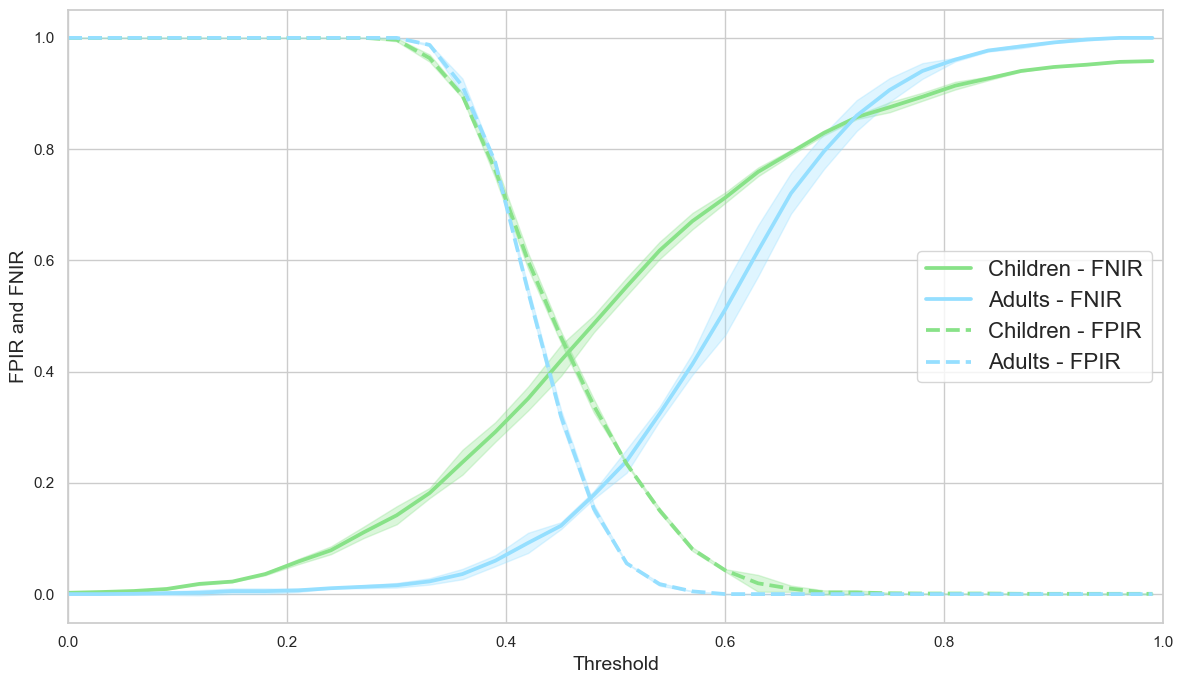

In [5]:

# plot_threshold_metrics_ex_1_1_together(df_all_threshold_x, 'AdaFace')
plot_threshold_metrics_ex_1_1_together_w_conf(df_all_threshold_x, 'AdaFace ex. 2.2', save_fig_path)

# Stats

In [4]:

random_states = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

df_all_results, sim_mat_dict_all_magface_ex1_1 = evaluate_metrics_ex_1_1(
    random_states, children_all, adults_all, image_names_c, image_names_a,
    sim_mat_c, sim_mat_a, num_ids_c, num_ids_a, ids_c, ids_a, balance_child_data,
    balance_adults_data_enrolled, compute_fnir, compute_fpir, GARBE, remove_ones, 0.180#df_all_threshold_x[df_all_threshold_x.FNIR_c <0.05].Threshold.max()
)

df_all_results.describe().applymap(lambda x: f"{x:.3f}")

NEW FPD result:  1.0
NEW FND result:  4.50747470101196
NEW GARBE result, GARBE close to 1 means more unfair:  3.63060602575897
done
NEW FPD result:  1.0
NEW FND result:  13.079092159559835
NEW GARBE result, GARBE close to 1 means more unfair:  10.059319119669876
done
NEW FPD result:  1.0
NEW FND result:  3.576096775460508
NEW GARBE result, GARBE close to 1 means more unfair:  2.932072581595381
done
NEW FPD result:  1.0
NEW FND result:  5.952975110189266
NEW GARBE result, GARBE close to 1 means more unfair:  4.71473133264195
done
NEW FPD result:  1.0
NEW FND result:  9.154300458715596
NEW GARBE result, GARBE close to 1 means more unfair:  7.115725344036697
done
NEW FPD result:  1.0
NEW FND result:  2.84862903705466
NEW GARBE result, GARBE close to 1 means more unfair:  2.386471777790995
done
NEW FPD result:  1.0
NEW FND result:  3.8891536587324964
NEW GARBE result, GARBE close to 1 means more unfair:  3.1668652440493723
done
NEW FPD result:  1.0
NEW FND result:  17.068504117108876
NEW G

/var/folders/hl/6j_44f453mvc5lr922s8d0l80000gn/T/ipykernel_6581/1969853084.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_all_results.describe().applymap(lambda x: f"{x:.3f}")


,Iteration,FNIR_c,FNIR_a,FPIR_c,FPIR_a,FPD,FND,GARBE,Threshold
count,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000
mean,5.500,0.033,0.006,1.000,1.000,1.000,7.168,5.626,0.180
std,3.028,0.003,0.003,0.000,0.000,0.000,4.642,3.481,0.000
min,1.000,0.029,0.002,1.000,1.000,1.000,2.849,2.386,0.180
25%,3.250,0.030,0.004,1.000,1.000,1.000,4.044,3.283,0.180
50%,5.500,0.033,0.006,1.000,1.000,1.000,5.327,4.245,0.180
75%,7.750,0.037,0.008,1.000,1.000,1.000,8.592,6.694,0.180
max,10.000,0.039,0.011,1.000,1.000,1.000,17.069,13.051,0.180


In [5]:
# Generate the LaTeX table
latex_table = generate_latex_table(df_all_results.applymap(lambda x: f"{x:.3f}").drop(columns='Iteration'))
print(latex_table)


\begin{table}
\caption{Descriptive Statistics} 
\label{table:descriptive_stats} 
\begin{tabular}{ccccccccc} 
\toprule
\textbf{{Iter.}} & $FNIR_c$ & $FNIR_a$ & $FPIR_c$ & $FPIR_a$ & $FPD$ & $FND$ & $GARBE$ & $T$ \\
\midrule
\textbf{0} & 0.035 & 0.008 & 1.000 & 1.000 & 1.000 & 4.507 & 3.631 & 0.180 \\
\textbf{1} & 0.037 & 0.003 & 1.000 & 1.000 & 1.000 & 13.079 & 10.059 & 0.180 \\
\textbf{2} & 0.037 & 0.010 & 1.000 & 1.000 & 1.000 & 3.576 & 2.932 & 0.180 \\
\textbf{3} & 0.039 & 0.006 & 1.000 & 1.000 & 1.000 & 5.953 & 4.715 & 0.180 \\
\textbf{4} & 0.033 & 0.004 & 1.000 & 1.000 & 1.000 & 9.154 & 7.116 & 0.180 \\
\textbf{5} & 0.030 & 0.011 & 1.000 & 1.000 & 1.000 & 2.849 & 2.386 & 0.180 \\
\textbf{6} & 0.030 & 0.008 & 1.000 & 1.000 & 1.000 & 3.889 & 3.167 & 0.180 \\
\textbf{7} & 0.032 & 0.002 & 1.000 & 1.000 & 1.000 & 17.069 & 13.051 & 0.180 \\
\textbf{8} & 0.029 & 0.004 & 1.000 & 1.000 & 1.000 & 6.906 & 5.430 & 0.180 \\
\textbf{9} & 0.030 & 0.006 & 1.000 & 1.000 & 1.000 & 4.701 & 3.776 & 0.

/var/folders/hl/6j_44f453mvc5lr922s8d0l80000gn/T/ipykernel_6581/3719310588.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  latex_table = generate_latex_table(df_all_results.applymap(lambda x: f"{x:.3f}").drop(columns='Iteration'))


In [6]:
latex_table = generate_latex_table(df_all_results.describe().applymap(lambda x: f"{x:.3f}").drop(columns='Iteration'))
print(latex_table)

\begin{table}
\caption{Descriptive Statistics} 
\label{table:descriptive_stats} 
\begin{tabular}{ccccccccc} 
\toprule
\textbf{{Iter.}} & $FNIR_c$ & $FNIR_a$ & $FPIR_c$ & $FPIR_a$ & $FPD$ & $FND$ & $GARBE$ & $T$ \\
\midrule
\textbf{count} & 10.000 & 10.000 & 10.000 & 10.000 & 10.000 & 10.000 & 10.000 & 10.000 \\
\textbf{mean} & 0.033 & 0.006 & 1.000 & 1.000 & 1.000 & 7.168 & 5.626 & 0.180 \\
\textbf{std} & 0.003 & 0.003 & 0.000 & 0.000 & 0.000 & 4.642 & 3.481 & 0.000 \\
\textbf{min} & 0.029 & 0.002 & 1.000 & 1.000 & 1.000 & 2.849 & 2.386 & 0.180 \\
\textbf{25%} & 0.030 & 0.004 & 1.000 & 1.000 & 1.000 & 4.044 & 3.283 & 0.180 \\
\textbf{50%} & 0.033 & 0.006 & 1.000 & 1.000 & 1.000 & 5.327 & 4.245 & 0.180 \\
\textbf{75%} & 0.037 & 0.008 & 1.000 & 1.000 & 1.000 & 8.592 & 6.694 & 0.180 \\
\textbf{max} & 0.039 & 0.011 & 1.000 & 1.000 & 1.000 & 17.069 & 13.051 & 0.180 \\
\bottomrule
\end{tabular} 
\end{table}



/var/folders/hl/6j_44f453mvc5lr922s8d0l80000gn/T/ipykernel_6581/2945641856.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  latex_table = generate_latex_table(df_all_results.describe().applymap(lambda x: f"{x:.3f}").drop(columns='Iteration'))


In [7]:
df_all_results.to_csv('df_all_results_ada_2_2.csv', index=False)


# Stats

In [8]:
t_statistic, p_value = stats.ttest_rel(df_all_results['FNIR_c'], df_all_results['FNIR_a'])

# Output the results
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

T-statistic: 19.031564753802133
P-value: 1.4060014588607782e-08


# Gemmer simscores

In [9]:

sim_mat_c_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_c_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_c_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

# Concatenate all arrays into one big array
sim_mat_c_enrolled_iterations_all = np.concatenate(sim_mat_c_enrolled_iterations)
sim_mat_c_enrolled_iterations_all = pd.DataFrame(sim_mat_c_enrolled_iterations_all)
sim_mat_c_enrolled_iterations_all.to_csv('sim_mat_c_enrolled_iterations_all_ada_2_2.csv', index=False)
# Print the big array
print(len(sim_mat_c_enrolled_iterations_all))

sim_mat_a_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_a_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_a_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

# Concatenate all arrays into one big array
sim_mat_a_enrolled_iterations_all = np.concatenate(sim_mat_a_enrolled_iterations)
sim_mat_a_enrolled_iterations_all = pd.DataFrame(sim_mat_a_enrolled_iterations_all)
sim_mat_a_enrolled_iterations_all.to_csv('sim_mat_a_enrolled_iterations_all_ada_2_2.csv', index=False)


# Print the big array
print(len(sim_mat_a_enrolled_iterations_all))

sim_mat_c_non_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_c_non_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_c_non_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

sim_mat_c_non_enrolled_iterations_all = np.concatenate(sim_mat_c_non_enrolled_iterations)
sim_mat_c_non_enrolled_iterations_all = pd.DataFrame(sim_mat_c_non_enrolled_iterations_all)
sim_mat_c_non_enrolled_iterations_all.to_csv('sim_mat_c_non_enrolled_iterations_all_ada_2_2.csv', index=False)
# Print the big array
print(len(sim_mat_c_non_enrolled_iterations_all))


sim_mat_a_non_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_a_non_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_a_non_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

sim_mat_a_non_enrolled_iterations_all = np.concatenate(sim_mat_a_non_enrolled_iterations)
sim_mat_a_non_enrolled_iterations_all = pd.DataFrame(sim_mat_a_non_enrolled_iterations_all)
sim_mat_a_non_enrolled_iterations_all.to_csv('sim_mat_a_non_enrolled_iterations_all_ada_2_2.csv', index=False)

# Print the big array
print(len(sim_mat_a_non_enrolled_iterations_all))


121238
41438
32751054
32371232


# loader sim scores

In [32]:
sim_mat_c_enrolled_iterations_all_ada = (pd.read_csv('sim_mat_c_enrolled_iterations_all_ada_2_2.csv')).values.flatten()
sim_mat_a_enrolled_iterations_all_ada = (pd.read_csv('sim_mat_a_enrolled_iterations_all_ada_2_2.csv')).values.flatten()
sim_mat_c_non_enrolled_iterations_all_ada = (pd.read_csv('sim_mat_c_non_enrolled_iterations_all_ada_2_2.csv')).values.flatten()
sim_mat_a_non_enrolled_iterations_all_ada = (pd.read_csv('sim_mat_a_non_enrolled_iterations_all_ada_2_2.csv')).values.flatten()


In [33]:
from scipy.stats import describe, gaussian_kde
import math

def descriptive_statistics(mated_scores, nonmated_scores):
    stats_labels = ["Observations", "Minimum", "Maximum", "Mean", "St. Dev.", "Skewness", "Ex. Kurtosis"]
    mated_stats = describe(mated_scores)
    mated_stats = [mated_stats.nobs, mated_stats.minmax[0], mated_stats.minmax[1], mated_stats.mean, math.sqrt(mated_stats.variance), mated_stats.skewness, mated_stats.kurtosis]
    nonmated_stats = describe(nonmated_scores)
    nonmated_stats = [nonmated_stats.nobs, nonmated_stats.minmax[0], nonmated_stats.minmax[1], nonmated_stats.mean, math.sqrt(nonmated_stats.variance), nonmated_stats.skewness, nonmated_stats.kurtosis]

    stats_system_df = pd.DataFrame(np.array([stats_labels, mated_stats, nonmated_stats]).T, columns=["Statistic", "Mated", "Non-mated"])
    stats_system_df = stats_system_df.astype({"Statistic": str, "Mated": float, "Non-mated": float})
    return stats_system_df

In [34]:
mated_scores1 = sim_mat_a_enrolled_iterations_all_ada
nonmated_scores1 = sim_mat_a_non_enrolled_iterations_all_ada
scores_type1 = "similarity"
stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
display(stats_system1_df)

,Statistic,Mated,Non-mated
0,Observations,41438.000000,3.237123e+07
1,Minimum,-0.066702,-3.113085e-01
2,Maximum,0.955272,6.407963e-01
3,Mean,0.621025,1.113240e-01
4,St. Dev.,0.122760,8.618000e-02
5,Skewness,-0.445137,2.053136e-01
6,Ex. Kurtosis,1.127336,2.417112e-01


In [35]:
mated_scores2 = sim_mat_c_enrolled_iterations_all_ada
nonmated_scores2 = sim_mat_c_non_enrolled_iterations_all_ada
scores_type2 = "similarity"
stats_system2_df = descriptive_statistics(mated_scores2, nonmated_scores2)
display(stats_system2_df)

,Statistic,Mated,Non-mated
0,Observations,121238.000000,3.275105e+07
1,Minimum,-0.068215,-3.808162e-01
2,Maximum,0.995631,9.998659e-01
3,Mean,0.520030,6.501443e-02
4,St. Dev.,0.168507,1.068352e-01
5,Skewness,-0.036605,3.493207e-01
6,Ex. Kurtosis,-0.186685,2.970495e-01


In [36]:
mated_colour = "green"
mated_label = "Mated scores"
nonmated_colour = "red"
nonmated_label = "Non-mated scores"

figure_size = (12,6)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 12
label_fontsize = 16

threshold_colour = "black"
threshold_style = "--"
round_digits = 5
sns.set(style="white", palette="muted", color_codes=True)
plt.rc("axes", axisbelow=True)

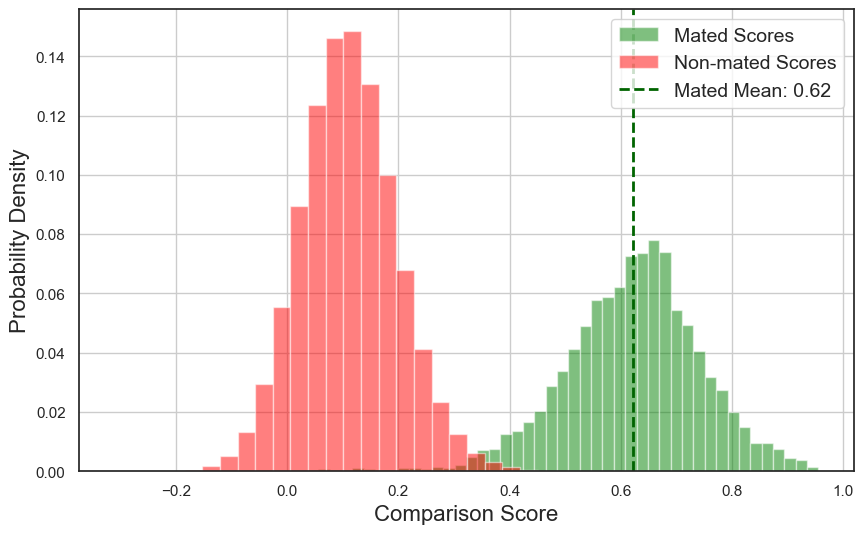

In [23]:
from DET_utils.DET_plots import *

plot_histogram(mated_scores1, nonmated_scores1, normalise=True, title = 'Adults - AdaFace ex. 2.2 ', save_fig_path = save_fig_path, gem_som='A1')


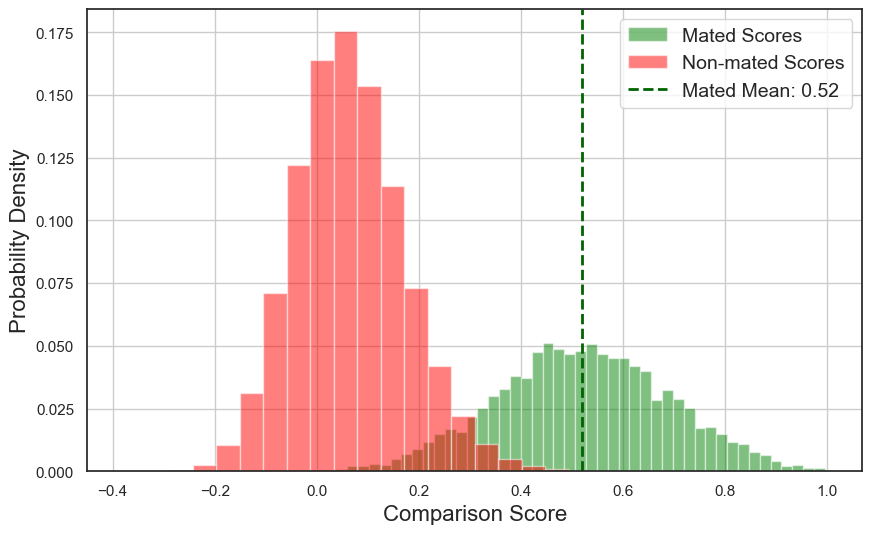

In [24]:
plot_histogram(mated_scores2, nonmated_scores2, normalise=True, title = 'Children - AdaFace ex. 2.2 ', save_fig_path=save_fig_path, gem_som='C1')


# DET curves


In [37]:
from DET_utils.DET_plots import *

In [38]:
d_prime_system1 = d_prime(mated_scores1, nonmated_scores1)
print("d' child =", round(d_prime_system1, round_digits))

d_prime_system2 = d_prime(mated_scores2, nonmated_scores2)
print("d' adult =", round(d_prime_system2, round_digits))


d' child = 4.80588
d' adult = 3.22519


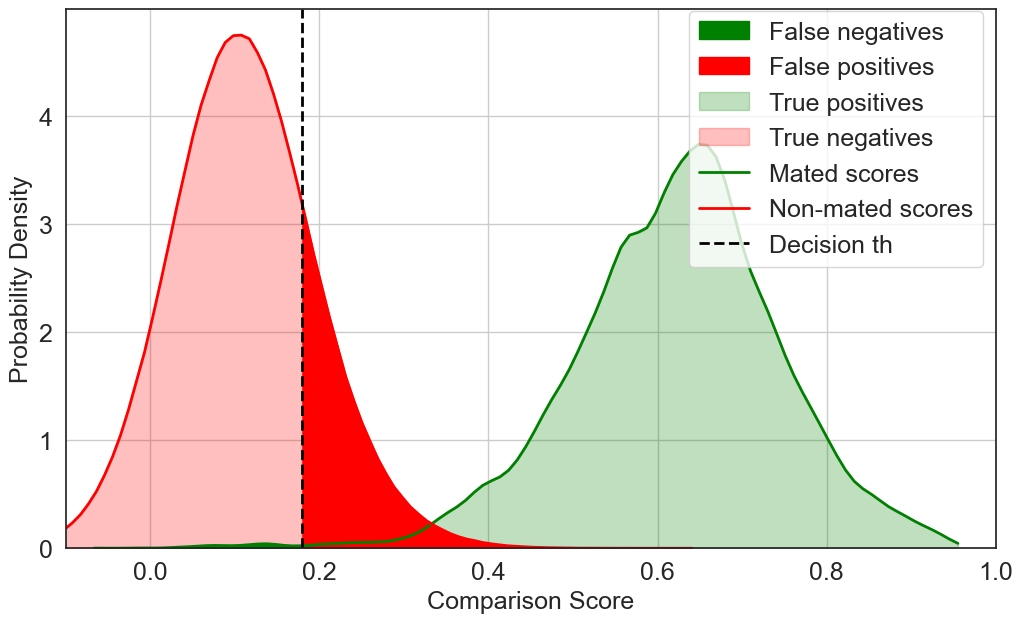

In [27]:
threshold1 = df_all_threshold_x[df_all_threshold_x.FNIR_c <0.05].Threshold.max()
kde_with_threshold(mated_scores1, nonmated_scores1, scores_type1, threshold1,save_fig_path=save_fig_path, title='A2')

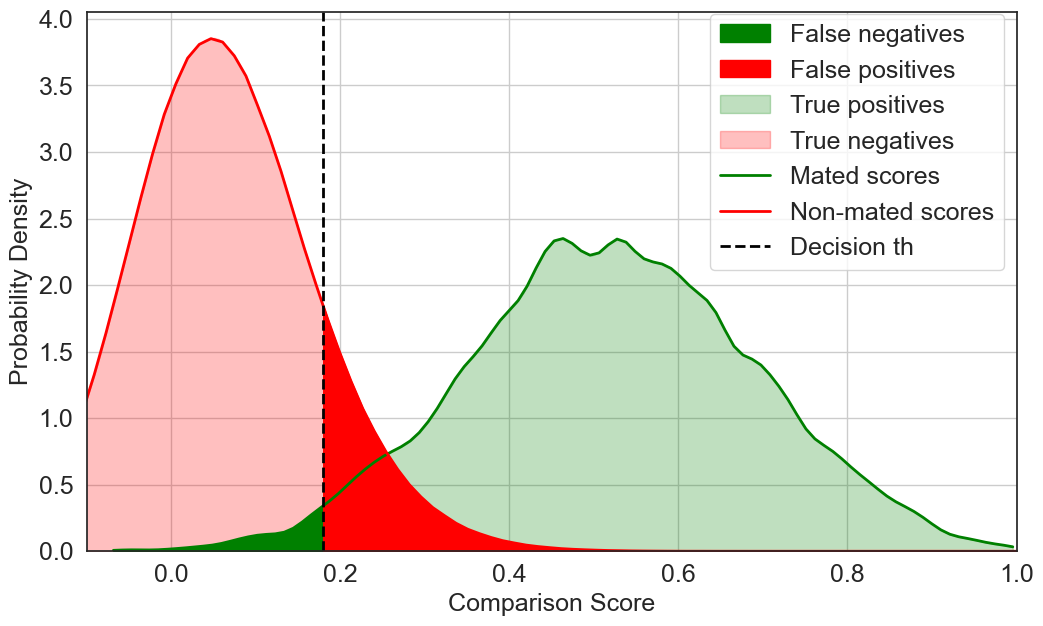

In [28]:
threshold2 = df_all_threshold_x[df_all_threshold_x.FNIR_c <0.05].Threshold.max()
kde_with_threshold(mated_scores2, nonmated_scores2, scores_type2, threshold2,save_fig_path=save_fig_path, title='C2')

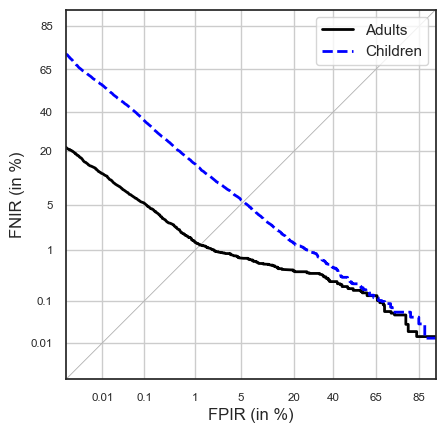

In [39]:
# Remember to save manually
import numpy as np

def DET_plotting_1_1(mated_scores1, mated_scores2,nonmated_scores1, nonmated_scores2, score_type= "similarity",title = 'Adults vs Children - MagFace ex. 2.2', save_fig_path= 'save_fig_path'):
    figure_size = (12,7)
    alpha_shade = 0.25
    alpha_fill = 1.0
    linewidth = 2
    legend_loc = "upper left"
    legend_anchor = (1.0, 1.02)
    legend_cols = 1
    legend_fontsize = 18
    label_fontsize = 18
    tick_fontsize = 18
    system_name1 = 'Adults'
    system_name2 = 'Children'

    det = DET(biometric_evaluation_type='identification', abbreviate_axes=True, plot_eer_line=True)#, plot_title=title)
    # det.x_limits = np.array([1e-5, .8])
    # det.y_limits = np.array([1e-5, .8])
    det.x_limits = np.array([1e-5, .9])
    det.y_limits = np.array([1e-5, .9])
    det.x_ticks = np.array([ 1e-4, 1e-3, 1e-2, 5e-2, 20e-2, 40e-2, 65e-2, 85e-2, 95e-2])
    det.x_ticklabels = np.array(['0.01', '0.1', '1', '5', '20', '40', '65', '85', '95'])
    det.y_ticks = np.array([ 1e-4, 1e-3, 1e-2, 5e-2, 20e-2, 40e-2, 65e-2, 85e-2, 95e-2])
    det.y_ticklabels = np.array([ '0.01', '0.1', '1', '5', '20', '40', '65', '85', '95'])

    det.create_figure()
    det.plot(tar=adjust_scores_for_DET(mated_scores1, score_type), non=adjust_scores_for_DET(nonmated_scores1, score_type), label=system_name1)
    det.plot(tar=adjust_scores_for_DET(mated_scores2, score_type), non=adjust_scores_for_DET(nonmated_scores2, score_type), label=system_name2)
    det.legend_on(loc="upper right")
    det.show()


DET_plotting_1_1(mated_scores1, mated_scores2,nonmated_scores1, nonmated_scores2, "similarity",'Adults vs Children - AdaFace ex. 2.2', save_fig_path= save_fig_path)
